In [1]:
import matplotlib.pyplot as plt
import os
import numpy as np
import earthpy.plot as ep
import seaborn as sns
import earthpy.spatial as es

import plotly.graph_objects as go
import plotly.express as px

from scipy.io import loadmat

import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score,
                             confusion_matrix, classification_report)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tqdm import tqdm

from metric_learn import LMNN
from sklearn.model_selection import StratifiedKFold

In [2]:
data = np.load('indianpinearray.npy')

gt = np.load('IPgt.npy')

df = pd.DataFrame(data.reshape(data.shape[0]*data.shape[1], -1))  #düzleştirip dataframe oluşturuyoruz

df.columns = [f'band{i}' for i in range(1, df.shape[-1]+1)]

df['class'] = gt.ravel()

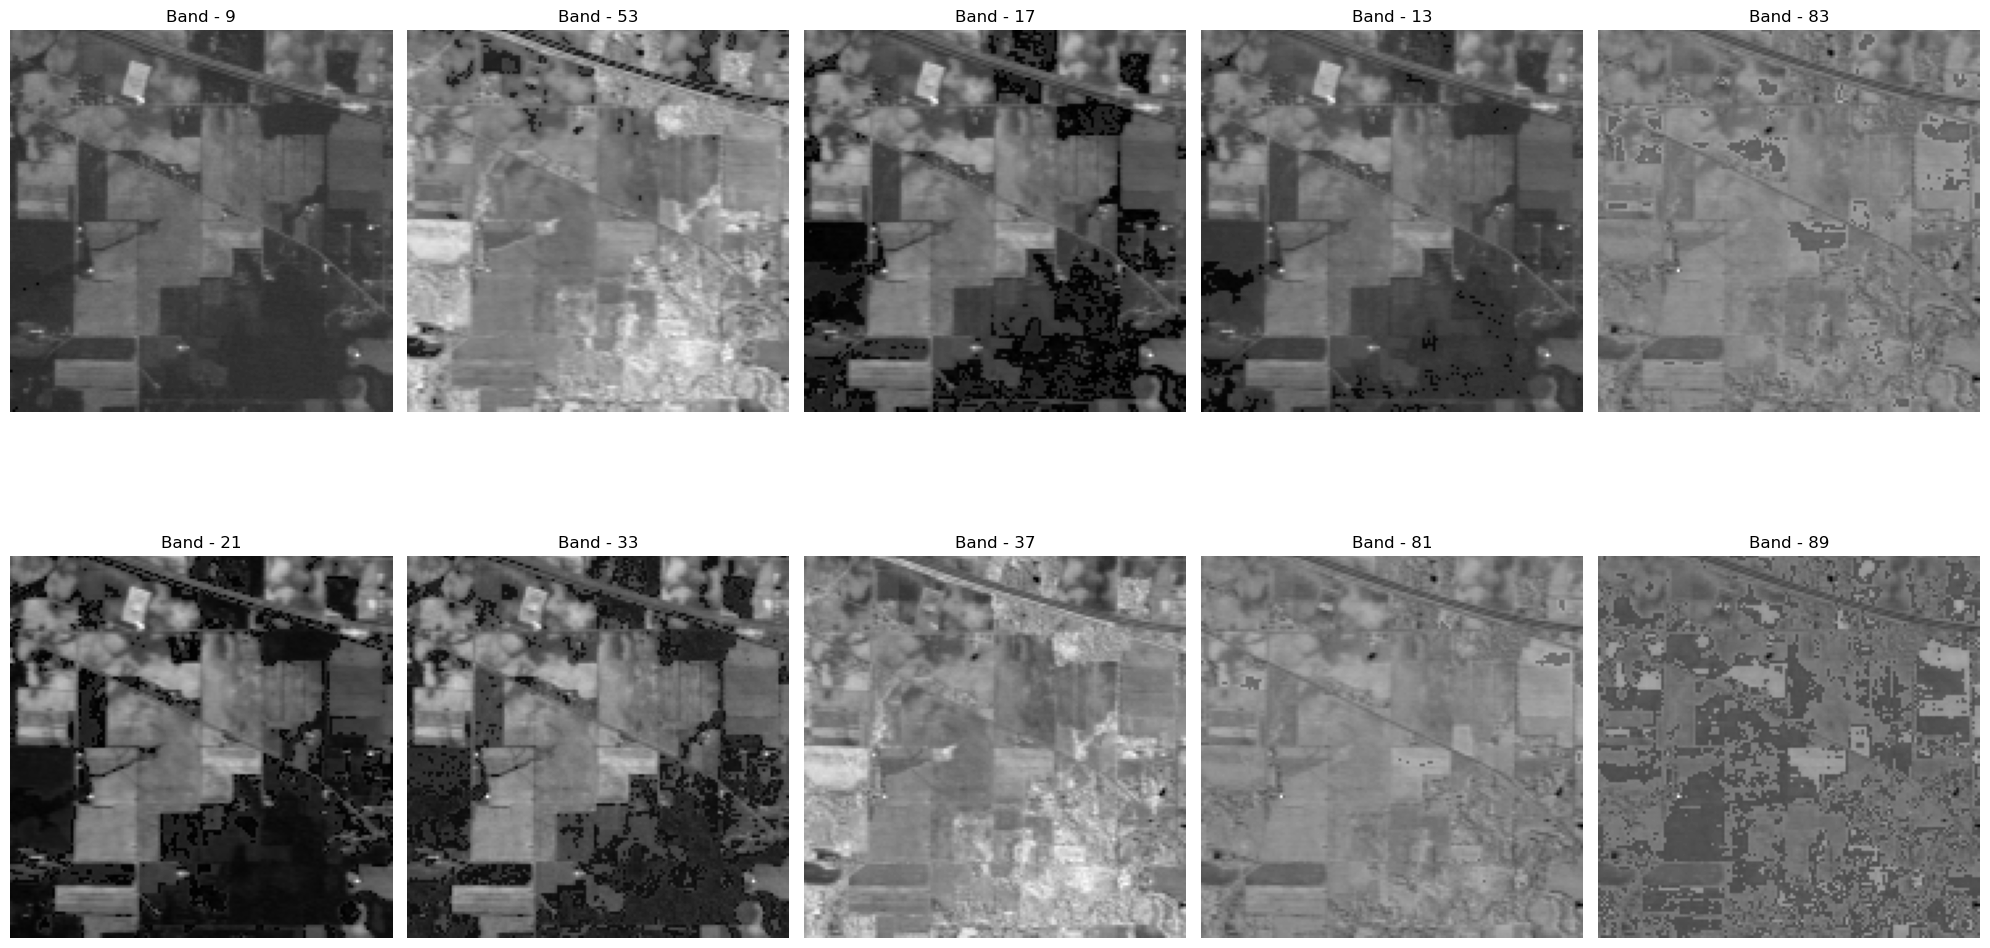

In [3]:
fig = plt.figure(figsize = (20, 12))

ax = fig.subplots(2, 5)

for i in range(2):
  for j in range(5):
    c = np.random.randint(103)
    ax[i][j].imshow(data[:, :, c], cmap='gray')
    ax[i][j].axis('off')
    ax[i][j].title.set_text(f"Band - {c}")
    c+=1

plt.tight_layout()

plt.show()

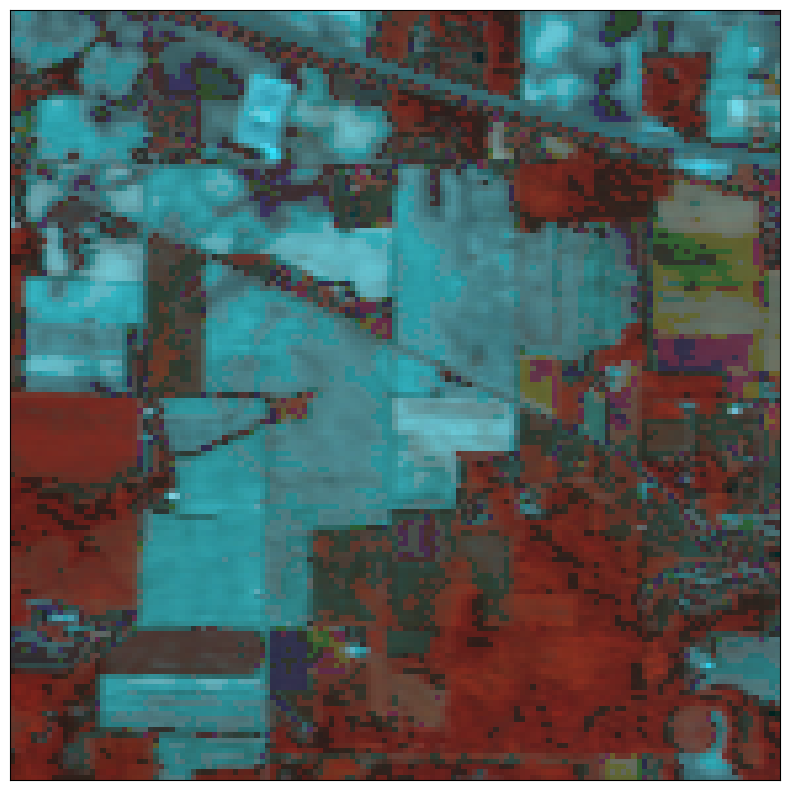

In [4]:
mdata = np.moveaxis(data, -1, 0)

ep.plot_rgb(mdata, (60, 30, 27), figsize=(12, 10)) 

plt.show()

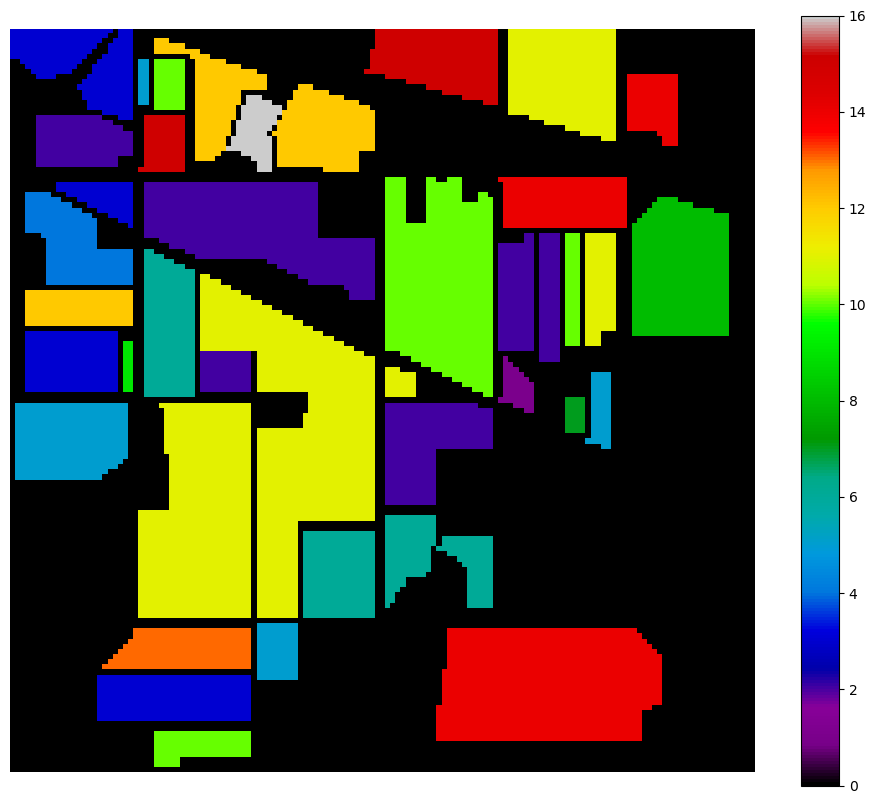

In [5]:
def plot_data(data):
  fig = plt.figure(figsize=(12, 10))
  plt.imshow(data, cmap='nipy_spectral')
  plt.colorbar()
  plt.axis('off')
  plt.show()

plot_data(gt)

In [6]:
X = df[df['class']!=0].iloc[:, :-1].values

y = df[df['class']!=0].iloc[:, -1].values

In [7]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from metric_learn import LMNN

veri = []

# LMNN modeli için parametreler
kf = KFold(n_splits=5, shuffle=True, random_state=42)

lmnn = LMNN(n_neighbors=2, learn_rate=1e-3)
knn = KNeighborsClassifier(n_neighbors=7)

fold_index = 1
for train_index, test_index in kf.split(X):
    print(f"Fold {fold_index} -> Train: {len(train_index)}, Test: {len(test_index)}")

    # Veri setini train ve test olarak bölmek
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Modeli eğitme
    lmnn.fit(X_train, y_train)
    knn.fit(lmnn.transform(X_train), y_train)

    # Compute the k-nearest neighbor test accuracy after applying the learned transformation
    lmnn_acc = knn.score(lmnn.transform(X_test), y_test)
    print('LMNN accuracy on test set of {} points: {:.4f}'.format(X_test.shape[0], lmnn_acc))

    veri.append(lmnn_acc)

    fold_index += 1

# Dizinin ortalamasını bulalım
ortalama = np.mean(veri)

# Dizinin standart sapmasını bulalım
standart_sapma = np.std(veri)

print("Veri kümesinin ortalaması:", ortalama)
print("Veri kümesinin standart sapması:", standart_sapma)

Fold 1 -> Train: 8199, Test: 2050
LMNN accuracy on test set of 2050 points: 0.8727
Fold 2 -> Train: 8199, Test: 2050
LMNN accuracy on test set of 2050 points: 0.8717
Fold 3 -> Train: 8199, Test: 2050
LMNN accuracy on test set of 2050 points: 0.8785
Fold 4 -> Train: 8199, Test: 2050
LMNN accuracy on test set of 2050 points: 0.8722
Fold 5 -> Train: 8200, Test: 2049
LMNN accuracy on test set of 2049 points: 0.8755
Veri kümesinin ortalaması: 0.8741341999071528
Veri kümesinin standart sapması: 0.0025744424990030916


In [8]:
y_pred = knn.predict(lmnn.transform(X_test))
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.8755490483162518
Confusion Matrix:
[[  7   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0 256   3   1   0   1   0   0   0   9  19   4   0   0   0   0]
 [  0  14 120   0   0   0   0   0   0   1  32   1   0   0   0   0]
 [  0   8   6  33   1   0   0   0   0   0   1   1   0   0   0   0]
 [  0   1   0   1  97   1   0   0   0   0   0   2   0   1   0   0]
 [  0   0   0   0   0 148   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   2   3   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  91   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   6   0   0   2   0   0   0   0   0   0   0]
 [  0   6   3   0   0   0   0   0   0 158  22   0   0   0   0   0]
 [  0  20   6   1   3   0   0   0   0  18 457   2   0   0   0   0]
 [  0   5   2   0   1   0   0   0   0   3  11  85   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  38   0   0   0]
 [  0   0   0   0   1   0   0   0   0   0   0   0   1 243   3   0]
 [  0   0   0  

In [9]:
from sklearn.metrics import accuracy_score

# Genel doğruluk hesaplama
genel_dogruluk = accuracy_score(y_test, y_pred)
print("Genel Doğruluk:", genel_dogruluk)

Genel Doğruluk: 0.8755490483162518


In [12]:
from sklearn.metrics import f1_score

# F-Measure hesaplama
f_measure = f1_score(y_test, y_pred, average='macro')
print("F-Measure:", f_measure)

F-Measure: 0.8357191979814986


In [11]:
from sklearn.metrics import cohen_kappa_score

# Kappa değeri hesaplama
kappa_degeri = cohen_kappa_score(y_test, y_pred)
print("Kappa Değeri:", kappa_degeri)

Kappa Değeri: 0.8567952077873455
